# PortPred-Pre-Alpha: overview and summary of the main analysis

### Some functions and modules

In [1]:
import numpy as np, pandas as pd, h5py, torch
import os
from Bio import SeqIO
import re

from typing import Union
from bio_embeddings.utilities import read_fasta
from bio_embeddings.embed import EmbedderInterface, SeqVecEmbedder
#from bio_embeddings.embed import ProtTransBertBFDEmbedder, ESM1bEmbedder
from tape import TAPETokenizer, UniRepModel, ProteinBertModel
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import requests
import pickle
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix,f1_score,recall_score,roc_auc_score,fbeta_score,make_scorer,balanced_accuracy_score,accuracy_score,matthews_corrcoef
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import utils_trans_2
import warnings

In [2]:
def avg_and_std_list(lr):
    res = []
    for x in zip(*lr):
        res.append([sum(x)/len(x), np.std(x)])
    return res


def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity


# Load the embedded sequence. Each of the following functions return either a dict (proteinID:embeddding_array) or just the embedding.
def load_unirep_embedding(dire, dictio=False):
    emb_list, emb_ids = [], []
    for e in os.listdir(dire):
        # print(e[:-11])
        emb_list.append(np.load(dire+'/'+e))
        ids = e[:-11]
        emb_ids.append(str(ids))
    emb = np.asarray(emb_list)
    if dictio:
        dic = {}
        for i, j in zip(emb_ids, emb):
            dic[i] = j
        return dic, emb
    else:
        return emb


def load_protbert_embedding(dire, dictio=False):
    emb_list, emb_ids = [], []
    for e in os.listdir(dire):
        # print(e[:-11])
        emb_list.append(np.load(dire+'/'+e))
        ids = e[:-13]
        emb_ids.append(str(ids))
    emb = np.asarray(emb_list)
    if dictio:
        dic = {}
        for i, j in zip(emb_ids, emb):
            dic[i] = j
        return dic, emb
    else:
        return emb


def load_esmb1_embedding(dire, dictio=False):
    emb_list, emb_ids = [], []
    for e in os.listdir(dire):
        # print(e[:-11])
        emb_list.append(np.load(dire+'/'+e))
        ids = e[:-10]
        emb_ids.append(str(ids))
    emb = np.asarray(emb_list)
    if dictio:
        dic = {}
        for i, j in zip(emb_ids, emb):
            dic[i] = j
        return dic, emb
    else:
        return emb


def load_seqvec_embedding(dire, dictio=False):
    emb_list, emb_ids = [], []
    for e in os.listdir(dire):
        # print(e[:-11])
        emb_list.append(np.load(dire+'/'+e))
        ids = e[:-11]
        emb_ids.append(str(ids))
    emb = np.asarray(emb_list)
    if dictio:
        dic = {}
        for i, j in zip(emb_ids, emb):
            dic[i] = j
        return dic, emb
    else:
        return emb

# Input emb must be a string stating which embedding is desired among: 'esmb1', 'unirep', 'seqvec', 'protbert'


def load_embedding(emb, dire, dictio=False):
    if emb == 'unirep':
        if dictio == True:
            dic, emb = load_unirep_embedding(dire, dictio=True)
            return dic, emb
        else:
            emb = load_unirep_embedding(dire, dictio=True)
            return emb
    if emb == 'seqvec':
        if dictio == True:
            dic, emb = load_seqvec_embedding(dire, dictio=True)
            return dic, emb
        else:
            emb = load_seqvec_embedding(dire, dictio=True)
            return emb
    if emb == 'esmb1':
        if dictio == True:
            dic, emb = load_esmb1_embedding(dire, dictio=True)
            return dic, emb
        else:
            emb = load_esmb1_embedding(dire, dictio=True)
            return emb
    if emb == 'protbert':
        if dictio == True:
            dic, emb = load_protbert_embedding(dire, dictio=True)
            return dic, emb
        else:
            emb = load_protbert_embedding(dire, dictio=True)
            return emb


# FUNCTIONS USEFUL FOR CV AND GRIDSEARCH:
def create_model_param_grid(method, class_weight, random_state=42):
    if method == 'LR':
        model = LogisticRegression(random_state=random_state)
        param_grid = {'solver': ['liblinear', 'saga'],
                      'penalty': ['l1', 'l2'],
                      'C': np.logspace(-3, 9, 13),
                      'class_weight': class_weight}
    elif method == 'SVM':
        model = SVC(random_state=random_state)
        param_grid = {'C': np.logspace(-2, 10, 13),
                      'gamma': np.logspace(-9, 3, 13),
                      'class_weight': class_weight}
    elif method == 'RF':
        model = RandomForestClassifier(random_state=random_state)
        param_grid = {'n_estimators': [15, 25, 50, 75, 100, 200, 300],
                      'criterion': ['gini', 'entropy'],
                      'max_depth': [2, 5, 10, None],
                      'min_samples_split': [2, 4, 8, 10],
                      'max_features': ['sqrt', 'auto', 'log2'],
                      'class_weight': class_weight}
    elif method == 'MLP':
        model = MLPClassifier(random_state=random_state)
        param_grid = {'hidden_layer_sizes': [(200,), (100,), (50,), (200, 100, 6, 1)],
                      'activation': ['relu'],
                      'solver': ['lbfgs'],
                      'alpha': [1.0],
                      'learning_rate': ['constant']}
    return model, param_grid


def create_X_y(pos, neg):
    #pos=np.asarray([pos.values()[key] for key in pos.values()])
    #neg=np.asarray([neg.values()[key] for key in neg.values()])
    X = np.concatenate((pos, neg), axis=0)
    y = np.concatenate((np.ones(len(pos)), np.zeros(len(neg))), axis=0)
    return X, y

In [3]:
class OneHotEmbedder(EmbedderInterface):

    name = "onehot"
    number_of_layers = 1

    def __init__(self, extended=False):
        super().__init__()
        if not extended:
            self._AMINO_ACIDS = np.asarray(list("ACDEFGHIKLMNPQRSTVWY"))
        else:
            self._AMINO_ACIDS = np.asarray(list("ACDEFGHIKLMNPQRSTVWYX"))
        self.embedding_dimension = len(self._AMINO_ACIDS)

    def embed(self, sequence: str) -> np.ndarray:
        sequence = re.sub(r"[UZOB]", "X", sequence)
        if sum([s in self._AMINO_ACIDS for s in sequence]) == len(sequence):
            return np.asarray([self._AMINO_ACIDS == s for s in sequence]).astype(np.float32)
        else:
            raise ValueError("Sequence contains unsupported characters.")

    @staticmethod
    def reduce_per_protein(embedding: np.ndarray) -> np.ndarray:
        return embedding.mean(axis=0)


class UniRepEmbedder(EmbedderInterface):

    name = "unirep"
    embedding_dimension = 1900
    number_of_layers = 1

    def __init__(self, device: Union[None, str, torch.device] = None, **kwargs):
        super().__init__(device, **kwargs)
        self._tokenizer = TAPETokenizer(vocab='unirep')
        self._model = UniRepModel.from_pretrained('babbler-1900').eval().to(self._device)

    def embed(self, sequence: str) -> np.ndarray:
        token_ids = torch.tensor([self._tokenizer.encode(sequence)]).to(self._device)
        with torch.no_grad():
            return self._model(token_ids)[0].squeeze()[1:-1].cpu().numpy()

    @staticmethod
    def reduce_per_protein(embedding: np.ndarray) -> np.ndarray:
        return embedding.mean(axis=0)


def init_model(emb_name):
    if emb_name == 'onehot':
        model = OneHotEmbedder(extended=True)
    elif emb_name == 'unirep':
        model = UniRepEmbedder()
    elif emb_name == 'seqvec':
        model = SeqVecEmbedder()
    elif emb_name == 'protbert':
        model = ProtTransBertBFDEmbedder()
    elif emb_name == 'esm1b':
        model = ESM1bEmbedder()
    return model
    
# function to obtain embedding
def get_embedding(emb_name, model, sequence):
    # embed sequence
    if emb_name in ['onehot', 'unirep', 'protbert', 'esm1b']:
        emb = model.embed(sequence)
    elif emb_name == 'seqvec':
        emb = model.embed(sequence)
        emb = emb.sum(0) # sums over 3 layers
    return emb

### Examples on how to generate the embeddings

In [4]:
#emb_name='unirep' # CHANGE HERE
#model = init_model(emb_name)

In [5]:
#emb = get_embedding(emb_name, model, seq)

In [6]:
#filename='Q9LVM1.fasta'

In [7]:
#with open(filename) as fastafile:
#    seqs={}
#    records = list(SeqIO.parse(fastafile, "fasta"))
#    for record in records:
#        if '|' not in record.id:
#            idx = record.id
#        else:
#            idx = record.id.split('|')[1]
#            seq = str(record.seq)
#            seqs[idx] = seq

In [8]:
#model_unirep=init_model('unirep')
#model_seqvec=init_model('seqvec')
#model_protbert=ProteinBertModel.from_pretrained('bert-base')
#model_esmb1=ESM1bEmbedder()

In [9]:
#emb_demo_unirep = get_embedding('unirep',model_unirep, seqs['Q9LVM1'])
#emb_demo_seqvec = get_embedding('seqvec',model_seqvec, seqs['Q9LVM1'])
#emb_demo_protbert= get_embedding('protbert',model_protbert, seqs['Q9LVM1'])
#emb_demo_esm1b= get_embedding('esm1b',model_esm1b, seqs['Q9LVM1'])

In [10]:
#emb_demo=np.concatenate((emb_demo_unirep,emb_demo_seqvec,emb_demo_protbert,emb_demo_esm1b),axis=1)

In [11]:
#for k in esmb1_dict_train.keys():
#    full_train_dict_esmb_included[k]=np.concatenate((esmb1_dict_train[k],protbert_dict_train[k],seqvec_dict_tr

In [12]:
def load_ids(file):
    ids=[]
    with open(file) as f:
        for line in f:
            ids.append(line.rstrip())
    return ids

# The dataset (training and test)

In [13]:
protbert_dict_test,protbert_emb_test=load_embedding('protbert','ft_transporter_test_fasta_protbert',dictio=True)
esmb1_dict_test,esmb1_emb_test=load_embedding('esmb1','ft_transporter_test_fasta_esm1b/',dictio=True)
seqvec_dict_test,seqvec_emb_test=load_embedding('seqvec','ft_transporter_test_fasta_seqvec/',dictio=True)
unirep_dict_test,unirep_emb_test=load_unirep_embedding('ft_transporter_test_fasta_unirep/',dictio=True)

#train Ftrans
protbert_dict_train_ft,protbert_emb_train_ft=load_embedding('protbert','dataset_ftrans/ft_transporter/ft_transporter_train_fasta_protbert/',dictio=True)
esmb1_dict_train_ft,esmb1_emb_train_ft=load_embedding('esmb1','dataset_ftrans/ft_transporter/ft_transporter_train_fasta_esm1b/',dictio=True)
seqvec_dict_train_ft,seqvec_emb_train_ft=load_embedding('seqvec','dataset_ftrans/ft_transporter/ft_transporter_train_fasta_seqvec/',dictio=True)
unirep_dict_train_ft,unirep_emb_train_ft=load_unirep_embedding('dataset_ftrans/ft_transporter/ft_transporter_train_fasta_unirep/',dictio=True)

In [14]:
#train 
amino_ids_train=load_ids('dataset_ftrans/Dataset/Train20Fasta/amino_train.ids')
electro_ids_train=load_ids('dataset_ftrans/Dataset/Train20Fasta/electron_train.ids')
sugar_ids_train=load_ids('dataset_ftrans/Dataset/Train20Fasta/sugar_train.ids')
protein_ids_train=load_ids('dataset_ftrans/Dataset/Train20Fasta/protein_train.ids')
hion_ids_train=load_ids('dataset_ftrans/Dataset/Train20Fasta/hion_train.ids')
lipid_ids_train=load_ids('dataset_ftrans/Dataset/Train20Fasta/lipid_train.ids')
other_ids_train=load_ids('dataset_ftrans/Dataset/Train20Fasta/others_train.ids')


#test ftrans
amino_ids_test=load_ids('Test20Fasta/Amino acid/amino.ids')
electro_ids_test=load_ids('Test20Fasta/Electron/electro.ids')
sugar_ids_test=load_ids('Test20Fasta/Sugar/sugar.ids')
protein_ids_test=load_ids('Test20Fasta/Protein mRNA/proteinmrna.ids')
hion_ids_test=load_ids('Test20Fasta/Hydrogen ion/Hion.ids')
lipid_ids_test=load_ids('Test20Fasta/Lipid/lipid.ids')
other_ids_test=load_ids('Test20Fasta/Others/others.ids')

In [15]:
##amino train ftrans
amino_protbert_ft,amino_unirep_ft,amino_seqvec_ft,amino_esmb1_ft={},{},{},{}
for k,v in protbert_dict_train_ft.items():
    if k in amino_ids_train:
        amino_protbert_ft[k]=v
for k,v in unirep_dict_train_ft.items():
    if k in amino_ids_train:
        amino_unirep_ft[k]=v
for k,v in seqvec_dict_train_ft.items():
    if k in amino_ids_train:
        amino_seqvec_ft[k]=v
for k,v in esmb1_dict_train_ft.items():
    if k in amino_ids_train:
        amino_esmb1_ft[k]=v
print('Amino  Ftrans  Uni,Seq,Pro,Esm: '+str(len(amino_unirep_ft))+' '+str(len(amino_seqvec_ft))+' '+\
      str(len(amino_protbert_ft))+' '+str(len(amino_esmb1_ft)))

##amino test ftrans
amino_protbert_test,amino_unirep_test,amino_seqvec_test,amino_esmb1_test={},{},{},{}
for k,v in protbert_dict_test.items():
    if k in amino_ids_test:
        amino_protbert_test[k]=v
for k,v in unirep_dict_test.items():
    if k in amino_ids_test:
        amino_unirep_test[k]=v
for k,v in seqvec_dict_test.items():
    if k in amino_ids_test:
        amino_seqvec_test[k]=v
for k,v in esmb1_dict_test.items():
    if k in amino_ids_test:
        amino_esmb1_test[k]=v
print('Test  Uni,Seq,Pro,Esm: '+str(len(amino_unirep_test))+' '+str(len(amino_seqvec_test))+' '+\
      str(len(amino_protbert_test))+' '+str(len(amino_esmb1_test)))
print('\n')


##electro train ftrans
electro_protbert_ft,electro_unirep_ft,electro_seqvec_ft,electro_esmb1_ft={},{},{},{}
for k,v in protbert_dict_train_ft.items():
    if k in electro_ids_train:
        electro_protbert_ft[k]=v
for k,v in unirep_dict_train_ft.items():
    if k in electro_ids_train:
        electro_unirep_ft[k]=v
for k,v in seqvec_dict_train_ft.items():
    if k in electro_ids_train:
        electro_seqvec_ft[k]=v
for k,v in esmb1_dict_train_ft.items():
    if k in electro_ids_train:
        electro_esmb1_ft[k]=v
print('Elect Ftrans   Uni,Seq,Pro,Esm: '+str(len(electro_unirep_ft))+' '+str(len(electro_seqvec_ft))+' '+\
      str(len(electro_protbert_ft))+' '+str(len(electro_esmb1_ft)))

#electro test
electro_protbert_test,electro_unirep_test,electro_seqvec_test,electro_esmb1_test={},{},{},{}
for k,v in protbert_dict_test.items():
    if k in electro_ids_test:
        electro_protbert_test[k]=v
for k,v in unirep_dict_test.items():
    if k in electro_ids_test:
        electro_unirep_test[k]=v
for k,v in seqvec_dict_test.items():
    if k in electro_ids_test:
        electro_seqvec_test[k]=v
for k,v in esmb1_dict_test.items():
    if k in electro_ids_test:
        electro_esmb1_test[k]=v
print('TEst Uni,Seq,Pro,Esm: '+str(len(electro_unirep_test))+' '+str(len(electro_seqvec_test))+' '+\
      str(len(electro_protbert_test))+' '+str(len(electro_esmb1_test)))
print('\n')


#hion train ftrans
hion_protbert_ft,hion_unirep_ft,hion_seqvec_ft,hion_esmb1_ft={},{},{},{}
for k,v in protbert_dict_train_ft.items():
    if k in hion_ids_train:
        hion_protbert_ft[k]=v
for k,v in unirep_dict_train_ft.items():
    if k in hion_ids_train:
        hion_unirep_ft[k]=v
for k,v in seqvec_dict_train_ft.items():
    if k in hion_ids_train:
        hion_seqvec_ft[k]=v
for k,v in esmb1_dict_train_ft.items():
    if k in hion_ids_train:
        hion_esmb1_ft[k]=v
print('Hion+ ftrans  Uni,Seq,Pro,Esm: '+str(len(hion_unirep_ft))+' '+str(len(hion_seqvec_ft))+' '+\
      str(len(hion_protbert_ft))+' '+str(len(hion_esmb1_ft)))

#hion test
hion_protbert_test,hion_unirep_test,hion_seqvec_test,hion_esmb1_test={},{},{},{}
for k,v in protbert_dict_test.items():
    if k in hion_ids_test:
        hion_protbert_test[k]=v
for k,v in unirep_dict_test.items():
    if k in hion_ids_test:
        hion_unirep_test[k]=v
for k,v in seqvec_dict_test.items():
    if k in hion_ids_test:
        hion_seqvec_test[k]=v
for k,v in esmb1_dict_test.items():
    if k in hion_ids_test:
        hion_esmb1_test[k]=v
print('Test Uni,Seq,Pro,Esm: '+str(len(hion_unirep_test))+' '+str(len(hion_seqvec_test))+' '+\
      str(len(hion_protbert_test))+' '+str(len(hion_esmb1_test)))
print('\n')


#sugar train Ftrans
sugar_protbert_ft,sugar_unirep_ft,sugar_seqvec_ft,sugar_esmb1_ft={},{},{},{}
for k,v in protbert_dict_train_ft.items():
    if k in sugar_ids_train:
        sugar_protbert_ft[k]=v
for k,v in unirep_dict_train_ft.items():
    if k in sugar_ids_train:
        sugar_unirep_ft[k]=v
for k,v in seqvec_dict_train_ft.items():
    if k in sugar_ids_train:
        sugar_seqvec_ft[k]=v
for k,v in esmb1_dict_train_ft.items():
    if k in sugar_ids_train:
        sugar_esmb1_ft[k]=v
print('Sugar Ftrans  Uni,Seq,Pro,Esm: '+str(len(sugar_unirep_ft))+' '+str(len(sugar_seqvec_ft))+' '+\
      str(len(sugar_protbert_ft))+' '+str(len(sugar_esmb1_ft)))

#sugar test
sugar_protbert_test,sugar_unirep_test,sugar_seqvec_test,sugar_esmb1_test={},{},{},{}
for k,v in protbert_dict_test.items():
    if k in sugar_ids_test:
        sugar_protbert_test[k]=v
for k,v in unirep_dict_test.items():
    if k in sugar_ids_test:
        sugar_unirep_test[k]=v
for k,v in seqvec_dict_test.items():
    if k in sugar_ids_test:
        sugar_seqvec_test[k]=v
for k,v in esmb1_dict_test.items():
    if k in sugar_ids_test:
        sugar_esmb1_test[k]=v
print('Test Uni,Seq,Pro,Esm: '+str(len(sugar_unirep_test))+' '+str(len(sugar_seqvec_test))+' '+\
      str(len(sugar_protbert_test))+' '+str(len(sugar_esmb1_test)))
print('\n')


#protein train Ftrans
protein_protbert_ft,protein_unirep_ft,protein_seqvec_ft,protein_esmb1_ft={},{},{},{}
for k,v in protbert_dict_train_ft.items():
    if k in protein_ids_train:
        protein_protbert_ft[k]=v
for k,v in unirep_dict_train_ft.items():
    if k in protein_ids_train:
        protein_unirep_ft[k]=v
for k,v in seqvec_dict_train_ft.items():
    if k in protein_ids_train:
        protein_seqvec_ft[k]=v
for k,v in esmb1_dict_train_ft.items():
    if k in protein_ids_train:
        protein_esmb1_ft[k]=v
print('Prote Ftrans  Uni,Seq,Pro,Esm: '+str(len(protein_unirep_ft))+' '+str(len(protein_seqvec_ft))+' '+\
      str(len(protein_protbert_ft))+' '+str(len(protein_esmb1_ft)))

#protein test
protein_protbert_test,protein_unirep_test,protein_seqvec_test,protein_esmb1_test={},{},{},{}
for k,v in protbert_dict_test.items():
    if k in protein_ids_test:
        protein_protbert_test[k]=v
for k,v in unirep_dict_test.items():
    if k in protein_ids_test:
        protein_unirep_test[k]=v
for k,v in seqvec_dict_test.items():
    if k in protein_ids_test:
        protein_seqvec_test[k]=v
for k,v in esmb1_dict_test.items():
    if k in protein_ids_test:
        protein_esmb1_test[k]=v
print('Test  Uni,Seq,Pro,Esm: '+str(len(protein_unirep_test))+' '+str(len(protein_seqvec_test))+' '+\
      str(len(protein_protbert_test))+' '+str(len(protein_esmb1_test)))
print('\n')


#lipid train Ftrans
lipid_protbert_ft,lipid_unirep_ft,lipid_seqvec_ft,lipid_esmb1_ft={},{},{},{}
for k,v in protbert_dict_train_ft.items():
    if k in lipid_ids_train:
        lipid_protbert_ft[k]=v
for k,v in unirep_dict_train_ft.items():
    if k in lipid_ids_train:
        lipid_unirep_ft[k]=v
for k,v in seqvec_dict_train_ft.items():
    if k in lipid_ids_train:
        lipid_seqvec_ft[k]=v
for k,v in esmb1_dict_train_ft.items():
    if k in lipid_ids_train:
        lipid_esmb1_ft[k]=v
print('Lipid  Uni,Seq,Pro,Esm: '+str(len(lipid_unirep_ft))+' '+str(len(lipid_seqvec_ft))+' '+\
      str(len(lipid_protbert_ft))+' '+str(len(lipid_esmb1_ft)))

#lipid test
lipid_protbert_test,lipid_unirep_test,lipid_seqvec_test,lipid_esmb1_test={},{},{},{}
for k,v in protbert_dict_test.items():
    if k in lipid_ids_test:
        lipid_protbert_test[k]=v
for k,v in unirep_dict_test.items():
    if k in lipid_ids_test:
        lipid_unirep_test[k]=v
for k,v in seqvec_dict_test.items():
    if k in lipid_ids_test:
        lipid_seqvec_test[k]=v
for k,v in esmb1_dict_test.items():
    if k in lipid_ids_test:
        lipid_esmb1_test[k]=v
print('test  Uni,Seq,Pro,Esm: '+str(len(lipid_unirep_test))+' '+str(len(lipid_seqvec_test))+' '+\
      str(len(lipid_protbert_test))+' '+str(len(lipid_esmb1_test)))
print('\n')


#other train Ftrans
other_protbert_ft,other_unirep_ft,other_seqvec_ft,other_esmb1_ft={},{},{},{}
for k,v in protbert_dict_train_ft.items():
    if k in other_ids_train:
        other_protbert_ft[k]=v
for k,v in unirep_dict_train_ft.items():
    if k in other_ids_train:
        other_unirep_ft[k]=v
for k,v in seqvec_dict_train_ft.items():
    if k in other_ids_train:
        other_seqvec_ft[k]=v
for k,v in esmb1_dict_train_ft.items():
    if k in other_ids_train:
        other_esmb1_ft[k]=v
print('Other Ftrans  Uni,Seq,Pro,Esm: '+str(len(other_unirep_ft))+' '+str(len(other_seqvec_ft))+' '+\
      str(len(other_protbert_ft))+' '+str(len(other_esmb1_ft)))

#other test
other_protbert_test,other_unirep_test,other_seqvec_test,other_esmb1_test={},{},{},{}
for k,v in protbert_dict_test.items():
    if k in other_ids_test:
        other_protbert_test[k]=v
for k,v in unirep_dict_test.items():
    if k in other_ids_test:
        other_unirep_test[k]=v
for k,v in seqvec_dict_test.items():
    if k in other_ids_test:
        other_seqvec_test[k]=v
for k,v in esmb1_dict_test.items():
    if k in other_ids_test:
        other_esmb1_test[k]=v
print('test  Uni,Seq,Pro,Esm: '+str(len(other_unirep_test))+' '+str(len(other_seqvec_test))+' '+\
      str(len(other_protbert_test))+' '+str(len(other_esmb1_test)))

Amino  Ftrans  Uni,Seq,Pro,Esm: 61 61 61 61
Test  Uni,Seq,Pro,Esm: 12 12 12 12


Elect Ftrans   Uni,Seq,Pro,Esm: 184 184 184 181
TEst Uni,Seq,Pro,Esm: 37 37 37 37


Hion+ ftrans  Uni,Seq,Pro,Esm: 73 73 73 73
Test Uni,Seq,Pro,Esm: 15 15 15 14


Sugar Ftrans  Uni,Seq,Pro,Esm: 71 71 71 71
Test Uni,Seq,Pro,Esm: 13 13 13 13


Prote Ftrans  Uni,Seq,Pro,Esm: 380 380 380 330
Test  Uni,Seq,Pro,Esm: 75 75 75 58


Lipid  Uni,Seq,Pro,Esm: 66 66 66 52
test  Uni,Seq,Pro,Esm: 12 12 12 9


Other Ftrans  Uni,Seq,Pro,Esm: 165 165 165 152
test  Uni,Seq,Pro,Esm: 33 33 33 32


In [16]:
X_seqvec_test=np.asarray(list(other_seqvec_test.values())[:len(other_esmb1_test)]+\
                          list(electro_seqvec_test.values())[:len(electro_esmb1_test)]+\
                          list(hion_seqvec_test.values())[:len(hion_esmb1_test)]+\
                          list(protein_seqvec_test.values())[:len(protein_esmb1_test)]+\
                          list(sugar_seqvec_test.values())+\
                          list(lipid_seqvec_test.values())[:len(lipid_esmb1_test)]+\
                          list(amino_seqvec_test.values()))
X_unirep_test=np.asarray(list(other_unirep_test.values())[:len(other_esmb1_test)]+\
                          list(electro_unirep_test.values())[:len(electro_esmb1_test)]+\
                          list(hion_unirep_test.values())[:len(hion_esmb1_test)]+\
                          list(protein_unirep_test.values())[:len(protein_esmb1_test)]+\
                          list(sugar_unirep_test.values())+\
                          list(lipid_unirep_test.values())[:len(lipid_esmb1_test)]+\
                          list(amino_unirep_test.values()))
X_protbert_test=np.asarray(list(other_protbert_test.values())[:len(other_esmb1_test)]+\
                          list(electro_protbert_test.values())[:len(electro_esmb1_test)]+\
                          list(hion_protbert_test.values())[:len(hion_esmb1_test)]+\
                          list(protein_protbert_test.values())[:len(protein_esmb1_test)]+\
                          list(sugar_protbert_test.values())+\
                          list(lipid_protbert_test.values())[:len(lipid_esmb1_test)]+\
                          list(amino_protbert_test.values()))
X_esmb1_test=np.asarray(list(other_esmb1_test.values())+list(electro_esmb1_test.values())+\
                          list(hion_esmb1_test.values())+list(protein_esmb1_test.values())+\
                          list(sugar_esmb1_test.values())+list(lipid_esmb1_test.values())+\
                          list(amino_esmb1_test.values()))
#X_unirep_train=np.asarray(list(unirep_dict_train.values()))
X_test=np.concatenate((X_unirep_test,X_seqvec_test,X_protbert_test,X_esmb1_test),axis=1)


X_seqvec_train_ft=np.asarray(list(other_seqvec_ft.values())[:len(other_esmb1_ft)]+\
                          list(electro_seqvec_ft.values())[:len(electro_esmb1_ft)]+\
                          list(hion_seqvec_ft.values())[:len(hion_esmb1_ft)]+\
                          list(protein_seqvec_ft.values())[:len(protein_esmb1_ft)]+\
                          list(sugar_seqvec_ft.values())+\
                          list(lipid_seqvec_ft.values())[:len(lipid_esmb1_ft)]+\
                          list(amino_seqvec_ft.values()))
X_unirep_train_ft=np.asarray(list(other_unirep_ft.values())[:len(other_esmb1_ft)]+\
                          list(electro_unirep_ft.values())[:len(electro_esmb1_ft)]+\
                          list(hion_unirep_ft.values())[:len(hion_esmb1_ft)]+\
                          list(protein_unirep_ft.values())[:len(protein_esmb1_ft)]+\
                          list(sugar_unirep_ft.values())+\
                          list(lipid_unirep_ft.values())[:len(lipid_esmb1_ft)]+\
                          list(amino_unirep_ft.values()))
X_protbert_train_ft=np.asarray(list(other_protbert_ft.values())[:len(other_esmb1_ft)]+\
                          list(electro_protbert_ft.values())[:len(electro_esmb1_ft)]+\
                          list(hion_protbert_ft.values())[:len(hion_esmb1_ft)]+\
                          list(protein_protbert_ft.values())[:len(protein_esmb1_ft)]+\
                          list(sugar_protbert_ft.values())+\
                          list(lipid_protbert_ft.values())[:len(lipid_esmb1_ft)]+\
                          list(amino_protbert_ft.values()))
X_esmb1_train_ft=np.asarray(list(other_esmb1_ft.values())+list(electro_esmb1_ft.values())+\
                          list(hion_esmb1_ft.values())+list(protein_esmb1_ft.values())+\
                          list(sugar_esmb1_ft.values())+list(lipid_esmb1_ft.values())+\
                          list(amino_esmb1_ft.values()))
#X_unirep_train=np.asarray(list(unirep_dict_train.values()))
X_train_ft=np.concatenate((X_unirep_train_ft,X_seqvec_train_ft,X_protbert_train_ft,X_esmb1_train_ft),axis=1)

In [17]:
y_test=np.asarray([0]*(len(other_esmb1_test))+[1]*len(electro_esmb1_test)+[2]*len(hion_esmb1_test)+\
             [3]*(len(protein_esmb1_test))+[4]*len(sugar_esmb1_test)+\
             [5]*(len(lipid_esmb1_test))+[6]*len(amino_esmb1_test))

y_train_ft=np.asarray([0]*(len(other_esmb1_ft))+[1]*len(electro_esmb1_ft)+[2]*len(hion_esmb1_ft)+\
             [3]*(len(protein_esmb1_ft))+[4]*len(sugar_esmb1_ft)+\
             [5]*(len(lipid_esmb1_ft))+[6]*len(amino_esmb1_ft))

## The main function 

In [18]:
def hybrid_embedding_RFE2(x,y,methods=['LR'],return_embedding_columns=True,random_state=[42],n_jobs=-1,\
                                     folds=10,refit='f1_macro',class_weight=[{0:1,1:1}],war='ignore',\
                                     results_filename='RESULTS'):
    class_weight=class_weight
    folds=folds
    refit=refit
    
    if war=='ignore':
        warnings.filterwarnings("ignore")
        for method in tqdm(methods, desc="Methods"):
            model_best_res=0
            results_iteration=[]
            for rs in tqdm(random_states, desc="random states"):
                current_best = 0
                cv = StratifiedKFold(n_splits=folds,shuffle=True,random_state=rs)
                M,p=create_model_param_grid(method,class_weight,random_state=rs)
                #print(M)
                mp = GridSearchCV(M, param_grid=p, cv=cv, return_train_score=True,\
                                scoring ={
                                'f1_macro':make_scorer(f1_score, average='macro'),\
                                'mcc':make_scorer(matthews_corrcoef)},\
                                verbose=1,n_jobs=n_jobs,refit=refit)
                
                           
                
                #print(mp)
                mp.verbose = False
                mp.fit(x,y)        

                results_full_1 = pd.DataFrame(pd.DataFrame(mp.cv_results_))
                
                results_rank=results_full_1.sort_values(by=['rank_test_f1_macro'])
                res=results_rank.filter(items=['mean_test_f1_macro','mean_test_mcc'])[:1].values[0]

                best_params = mp.best_params_

                current_results = mp.best_score_

                if current_results.max() > current_best:
                    current_best = current_results.max()
                    final_res=res
                            
                else:
                    break
                            

                results_iteration.append(final_res)

            all_res=avg_and_std_list(results_iteration)
            new_dict={}
            new_v=[]
            for lista in all_res:
                new_v.append([round(lista[0],4),round(lista[1],4)])
            new_dict['score']=new_v
            res_df=pd.DataFrame(new_dict)
            newcol=['f1_macro','mcc']

            res_df.insert(loc=0, column='metrics', value=newcol)
            res_df.to_csv(results_filename+'_'+method+'.csv',sep='\t')
            print('all features results:'+'\n',method,res_df)
            if method == 'LR':
                estimator = LogisticRegression(**best_params,multi_class='auto')
            else:
                mod = np.load('LRbest_hybrid_model_multiclass.sav',allow_pickle=True)
                estimator = mod
            list_of_n_of_selected_features,list_of_feature_ranks=[],[]    
            
            selector = RFECV(estimator,cv=folds, min_features_to_select=100, step=100, scoring='f1_macro')
            sel = selector.fit(x, y)
            n_of_selected_features=sel.n_features_
            list_of_n_of_selected_features.append(n_of_selected_features)
            list_of_feature_ranks.append(sel.ranking_)
            lofosf=np.asarray(list_of_n_of_selected_features)
            avg_n_of_selected_features=np.mean(lofosf)
            columns_list=[]
            df_x=pd.DataFrame(x)
            for i,j in zip(list_of_feature_ranks[0],df_x.columns):
                if i==1:
                    columns_list.append(j)
            columns4_emb=np.asarray(columns_list)
            with open('columns4_emb_multiclass.txt' ,'w') as f:
                for e in columns4_emb:
                    f.write(str(e)+'\t')
            new_emb=df_x[columns4_emb]
            print('\n')
            print('New embedding shape:',new_emb.shape)
            results_iteration =[]
            for rs in tqdm(random_states, desc="random states RFE"):
                current_best = 0
                cv = StratifiedKFold(n_splits=folds,shuffle=True,random_state=rs)
                M,p=create_model_param_grid(method,class_weight,random_state=rs)
                mp = GridSearchCV(M, param_grid=p, cv=cv, return_train_score=True,\
                                              scoring ={'f1_macro':make_scorer(f1_score, average='macro'),\
                                                        'mcc':make_scorer(matthews_corrcoef),\
                                                      },\
                                  verbose=1,n_jobs=n_jobs,refit=refit)

                mp.verbose = False
                mp.fit(new_emb,y)
                        

                results_full = pd.DataFrame(pd.DataFrame(mp.cv_results_))
                results_rank=results_full.sort_values(by=['rank_test_f1_macro'])
                res=results_rank.filter(items=['mean_test_f1_macro','mean_test_mcc','mean_test_accuracy'])[:1].values[0]

                best_params = mp.best_params_

                current_results = mp.best_score_

                if current_results.max() > current_best:
                    current_best = current_results.max()
                    final_res=res
                    #best_model=mp.best_estimator_
                        
                else:
                    break

                results_iteration.append(final_res)
                
                if final_res[0]>model_best_res:
                    model_best_res=final_res[0]
                    best_model=mp.best_estimator_
                    
            filename = results_filename+'_'+method+'best_hybrid_model_multiclass.sav'
            pickle.dump(best_model, open(filename, 'wb'))
                    
            
            all_res=avg_and_std_list(results_iteration)
            new_dict={}
            new_v=[]
            for lista in all_res:
                new_v.append([round(lista[0],4),round(lista[1],4)])
            new_dict['score']=new_v
            res_df=pd.DataFrame(new_dict)
            newcol=['f1_macro','mcc']

            res_df.insert(loc=0, column='metrics', value=newcol)
            res_df.to_csv(results_filename+'RFE'+'_'+method+'.csv',sep='\t')
            print('selected_features:'+'\n',method,res_df)
            if return_embedding_columns==True:
                return columns4_emb,best_model
            else:
                return best_model


## Analysis example

In [19]:
methods=['LR'] # add SVM,MLP,RF
random_states=[10] # add any random state (original analisis with 10)

#execute the main funcion showing results with all the concatenated embeddings and with the RFE embeddings
#for the multiclass prediction and save the hybird embedding.
#the selected features will be stored in a file called columns4_emb_multiclass.txt
features_selected,model=hybrid_embedding_RFE2(X_train_ft,y_train_ft,methods=methods,random_state=random_states,n_jobs=-1,results_filename='FT_multiclass_trainingsetCV_results')

#load the binary classification model and the multiclass model
model1=np.load('uni_prot_seqvec_ESMB_trainingsetCV_results_LR_all_features_model.sav',allow_pickle=True)
model2=model
#np.load('FT_multiclass_trainingsetCV_results_LRbest_hybrid_model_multiclass.sav',allow_pickle=True)
df_x=pd.DataFrame(X_test)
new_emb=df_x[features_selected]


all features results:
 LR     metrics          score
0  f1_macro  [0.9079, 0.0]
1       mcc  [0.9132, 0.0]


New embedding shape: (920, 2928)



selected_features:
 LR     metrics          score
0  f1_macro  [0.9316, 0.0]
1       mcc  [0.9393, 0.0]



In [20]:
y_pred_binary=model1.predict(X_test)
y_pred=model2.predict(new_emb)
multilabel_confusion_matrix(y_pred,y_test)
class_names=['other','electron','anion','protein_mrna','aminoacid','cation','sugar']
cnf_matrix = confusion_matrix(y_test, y_pred)
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# # Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# # Specificity or true negative rate
TNR = TN/(TN+FP) 
# # Precision or positive predictive value
PPV = TP/(TP+FP)
# # Negative predictive value
NPV = TN/(TN+FN)
# # Fall out or false positive rate
FPR = FP/(FP+TN)
# # False negative rate
FNR = FN/(TP+FN)
# # False discovery rate
FDR = FP/(TP+FP)
# # Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

F1=f1_score(y_test,y_pred,average='macro')
MCC=matthews_corrcoef(y_test,y_pred)

print('Binary prediction:',y_pred_binary)
print('\n'+'F1 score for multiclass: '+str(F1))
print('\n'+'MCC score for multiclass: '+str(MCC))

Binary prediction: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1.]

F1 score for multiclass: 0.9228343452774034

MCC score for multiclass: 0.9061660623290502


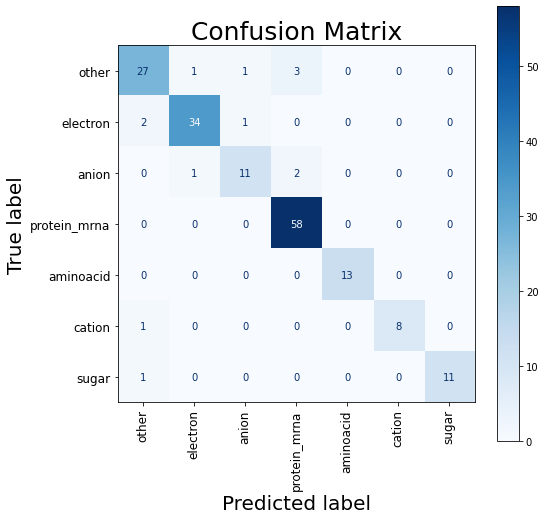

In [21]:
#plt.figure(figsize=(10, 10))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Confusion Matrix', fontsize=25)
ax.set_xticklabels(class_names,fontsize=12)
ax.set_yticklabels(class_names,fontsize=12) 
ax.set_xlabel('Predicted label',fontsize=20)
ax.set_ylabel('True label',fontsize=20)
#ax.xcorr(new_emb,y_test)
plot_confusion_matrix(model, new_emb, y_test, ax=ax, values_format='d',
                                 display_labels=class_names, xticks_rotation='vertical',
                                 cmap=plt.cm.Blues)

#plt.show()

In [25]:
model_demo=np.load('FT_multiclass_trainingsetCV_results_LRbest_hybrid_model_multiclass.sav',allow_pickle=True)
columns_4e=pd.read_csv('columns4_emb_multiclass.txt',sep='\t')
columns_4e = columns_4e.iloc[:, :-1]
col_list=[]
for e in columns_4e:
    col_list.append(int(e))
df_x=pd.DataFrame(X_test)
df=df_x[col_list]

model_demo.predict(df)

array([0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 2, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 0, 5, 5, 5, 5, 5, 5, 5, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6])